In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ------------------ A. Load & Preprocess Data ------------------
data = pd.read_csv(r"C:\Users\yashv\OneDrive\Desktop\housing.csv")

In [2]:
# Target column
target_col = "median_house_value"
y = data[target_col].values.reshape(-1, 1)

# Features
X = data.drop(columns=[target_col]).apply(pd.to_numeric, errors="coerce")

# Impute missing values (replace NaN with mean of each column)
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Add intercept (bias column)
X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]

C:\Users\yashv\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:565: UserWarning: Skipping features without any observed values: ['ocean_proximity']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [3]:
# ------------------ B. Normal Equation ------------------
theta_ne = np.linalg.pinv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train
y_pred_ne = X_test_bias @ theta_ne

# ------------------ C. Gradient Descent ------------------
def compute_mse(X, y, theta):
    n = len(y)
    predictions = X @ theta
    return (1 / (2 * n)) * np.sum((predictions - y) ** 2)

def gradient_descent(X, y, lr=0.01, n_iters=1000, tol=1e-6):
    n, d = X.shape
    theta = np.zeros((d, 1))
    loss_history = []

    for i in range(n_iters):
        gradients = (1 / n) * X.T @ (X @ theta - y)
        theta = theta - lr * gradients
        loss = compute_mse(X, y, theta)
        loss_history.append(loss)

        if i > 0 and abs(loss_history[-2] - loss_history[-1]) < tol:
            break

    return theta, loss_history

theta_gd, loss_history = gradient_descent(X_train_bias, y_train, lr=0.1, n_iters=1000)
y_pred_gd = X_test_bias @ theta_gd

# ------------------ D. Scikit-learn LinearRegression ------------------
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
y_pred_sklearn = model.predict(X_test)

In [4]:
# ------------------ E. Evaluation ------------------
def evaluate(y_true, y_pred, name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} -> MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")

evaluate(y_test, y_pred_ne, "Normal Equation")
evaluate(y_test, y_pred_gd, "Gradient Descent")
evaluate(y_test, y_pred_sklearn, "Scikit-learn")

Normal Equation -> MSE: 5052953703.9016, RMSE: 71084.1312, R²: 0.6144, MAE: 51835.7347
Gradient Descent -> MSE: 5029236419.3914, RMSE: 70917.1095, R²: 0.6162, MAE: 51748.6504
Scikit-learn -> MSE: 5052953703.9016, RMSE: 71084.1312, R²: 0.6144, MAE: 51835.7347


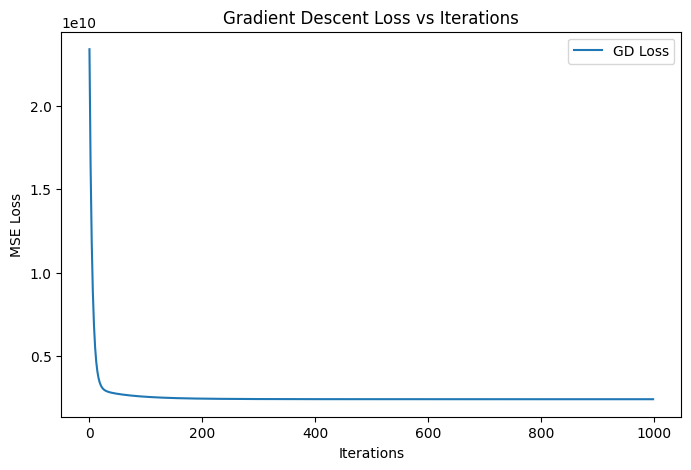

In [5]:
# ------------------ F. Visualizations ------------------
# 1) Loss vs iterations for Gradient Descent
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="GD Loss")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Gradient Descent Loss vs Iterations")
plt.legend()
plt.show()

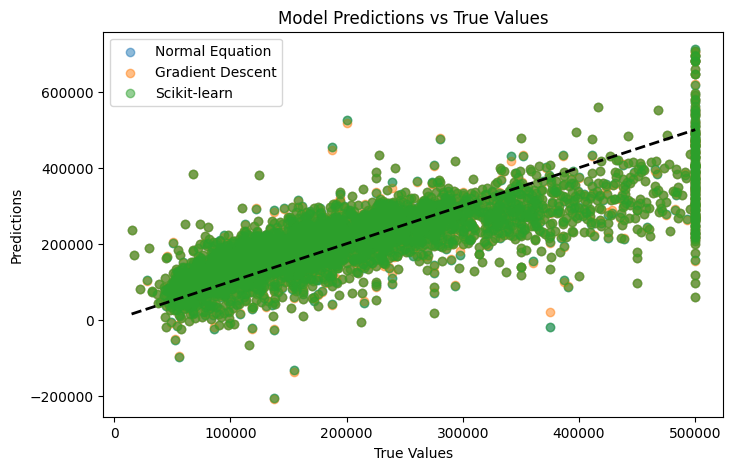

In [6]:
# 2) Predictions comparison scatter
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_ne, alpha=0.5, label="Normal Equation")
plt.scatter(y_test, y_pred_gd, alpha=0.5, label="Gradient Descent")
plt.scatter(y_test, y_pred_sklearn, alpha=0.5, label="Scikit-learn")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Model Predictions vs True Values")
plt.legend()
plt.show()